## Charlie: one hot encoded characters based text generation

This neural network is the simplest among the ones faced in this project. It uses sentences splitted into characters, which are then one hot encoded to provide a computer readable format as network input.

First step in the development of this neural network is the definition of its architecture by means of a grid search for a few epochs in order to compute loss and compare it among the parameters tested.

Once an architecture has been set and other optimal parameters such as length of the recurrent window and the type of the neural network have been found, the neural network is trained again on the whole dataset for many epochs to develop the final model, saving its weights in checkpoints at regular epochs interval, in order to avoid eventual loss of traning progress.

In [1]:
# Run on colab
ON_COLAB = False  
# Define colab directory
COLAB_PATH = '/content/drive/My Drive/UniPD/2019_20_Neural_Network_Deep_Learning/nndl-03'
# Hyperparameters grid search
HYPER_TRAIN = False
# Model training
MODEL_TRAIN = False
# Number of training epoch
NUM_EPOCHS = 4000
# Batch size
BATCH_SIZE = 100
# Epochs saving interval
SAVE_AFTER = 100
# Percentage of training examples
TRAIN_PERC = 0.96
# Size of each sentence
CROP_LEN = 25
# Define path to visualized model
# MODEL_PATH = 'data/charlie/2020_09_11_13_11_45'
MODEL_PATH = 'data/charlie/2020_09_11_15_07_27'

In [2]:
# Do only if colab setup has been chosen
if ON_COLAB:

    # Install some packages
    !pip install unidecode
    
    # Import google drive dependencies
    from google.colab import drive
    import os
    
    # Mount remote drive
    drive.mount('/content/drive', force_remount=True)
    # Change working directory
    os.chdir(COLAB_PATH)

In [3]:
# Dependencies
from src.dataset.transform import OneHotEncode, RandomCrop, ToTensor
from src.dataset.dataset import train_test_split
from src.dataset.dickens import DickensGE
from src.network.network import grid_search, save_epochs, load_epochs, train_test_epochs
from src.network.charlie import Charlie
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import optim, nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import torch
import json
import os

# Initialize torch random generator
torch.manual_seed(42)
# Initialize numpy random generator
np.random.seed(42)

# Instruct pandas to avoid newlines in columns
pd.set_option('display.expand_frame_repr', False)

# Setup plotting method
%matplotlib inline

In [4]:
# Define CPU device
cpu = torch.device('cpu')
# Define best device (GPU if available, CPU otherwise)
device = torch.device('cuda') if torch.cuda.is_available() else cpu

# Show selected device
device

device(type='cuda')

In [5]:
# Make dataset for first training, using sliding window
dataset = DickensGE.from_file('./data/great-expectations-dickens.txt', split_fn=DickensGE.split_chars, min_length=50)
# Show dataset length (number of kept paragraphs)
print('Dataset length:', len(dataset))

Dataset length: 3123


In [6]:
# Initialize alphabet (set of available characters)
alphabet = set()
# Go through each sentence in dataset
for i in range(len(dataset)):
    # Update alphabet
    alphabet |= set(dataset[i])
    
# Sort alphabet
alphabet = sorted(alphabet)
# Show alphabet
print(alphabet)

['\n', ' ', '!', '"', "'", ',', '.', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
# Define ranom crop
random_crop = RandomCrop(CROP_LEN)
# Define one hot encoder
one_hot_encode = OneHotEncode(alphabet)
# Define to tensor transform
to_tensor = ToTensor()

# Define transformation for dataset
dataset.transform = transforms.Compose([
  random_crop,
  one_hot_encode,
  to_tensor
])

In [8]:
# Show tensors shape

# Loop through first 3 sentences shapes
for i in range(3):
    # Print tensor shape
    print('Sentence nr {:d} has shape {:d} x {:d}:'.format(i+1, *dataset[i].shape))
    # Print sentence
    print(dataset.paragraphs[i])

Sentence nr 1 has shape 25 x 34:
['m', 'y', ' ', 'f', 'a', 't', 'h', 'e', 'r', "'", 's', ' ', 'f', 'a', 'm', 'i', 'l', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'b', 'e', 'i', 'n', 'g', ' ', 'p', 'i', 'r', 'r', 'i', 'p', ',', ' ', 'a', 'n', 'd', ' ', 'm', 'y', ' ', 'c', 'h', 'r', 'i', 's', 't', 'i', 'a', 'n', ' ', 'n', 'a', 'm', 'e', ' ', 'p', 'h', 'i', 'l', 'i', 'p', ',', ' ', 'm', 'y', ' ', 'i', 'n', 'f', 'a', 'n', 't', ' ', 't', 'o', 'n', 'g', 'u', 'e', ' ', 'c', 'o', 'u', 'l', 'd', ' ', 'm', 'a', 'k', 'e', ' ', 'o', 'f', ' ', 'b', 'o', 't', 'h', ' ', 'n', 'a', 'm', 'e', 's', ' ', 'n', 'o', 't', 'h', 'i', 'n', 'g', ' ', 'l', 'o', 'n', 'g', 'e', 'r', ' ', 'o', 'r', ' ', 'm', 'o', 'r', 'e', ' ', 'e', 'x', 'p', 'l', 'i', 'c', 'i', 't', ' ', 't', 'h', 'a', 'n', ' ', 'p', 'i', 'p', '.', ' ', 's', 'o', ',', ' ', 'i', ' ', 'c', 'a', 'l', 'l', 'e', 'd', ' ', 'm', 'y', 's', 'e', 'l', 'f', ' ', 'p', 'i', 'p', ',', ' ', 'a', 'n', 'd', ' ', 'c', 'a', 'm', 'e', ' ', 't', 'o', ' ', 'b', 'e', ' ', 'c', '

### Hyperparameters tuning

In [9]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = train_test_split(dataset, TRAIN_PERC)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# Do only if hyperparameters training is enabled
if HYPER_TRAIN:
    
    # Make parameters training
    train_losses, train_times, test_losses, test_times, params = grid_search(
        train_dl=train_dataloader, test_dl=test_dataloader,
        net=[Charlie], net__input_size=[len(alphabet)],
        net__hidden_units=[128, 256], net__layers_num=[2, 3],
        net__hidden_type=['GRU', 'LSTM'], net__dropout_prob=[0.3],
        optim=[optim.Adam], lr=[1e-3, 1e-4], optim__weight_decay=[1e-4, 1e-5],
        loss_fn=[nn.CrossEntropyLoss],
        num_epochs=10,
        verbose=True,
        device=device
    )

    # Store parameters to disk
    save_epochs(
        path='data/charlie/hyper.json',
        train_losses=train_losses,
        train_times=train_times,
        test_losses=test_losses,
        test_times=test_times,
        params=[{
            # Turn param value into string 
            str(kw): str(params[i][kw]) for kw in params[i]}
            # Loop through each parameter combination
            for i in range(len(params))
        ]
    )

In [11]:
# Load parameters from disk
train_losses, train_times, test_losses, test_times, others = load_epochs(
    path='data/charlie/hyper.json'
)

# Define common index
index = range(len(train_losses))
# Turn params into a dictionary itself
params = pd.DataFrame.from_records(data=others.get('params'), index=index)
# Make grid search results dataframe
results = pd.DataFrame(index=index, data={
    'train_loss': map(lambda x: x[-1], train_losses),
    'train_time': map(lambda x: x[-1], train_times),
    'test_loss': test_losses,
    'test_time': test_times
})
# Add parameters
results = pd.concat([results, params], axis=1)
# Sort by training loss and training time
results = results.sort_values(by=['test_loss', 'train_time'])
# Show grid search
results.head(3)

,train_loss,train_time,test_loss,test_time,net,net__input_size,net__hidden_units,net__layers_num,net__hidden_type,net__dropout_prob,optim,lr,optim__weight_decay,loss_fn
24,2.375344,0.849345,2.060565,0.014851,<class 'src.network.charlie.Charlie'>,34,256,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
25,2.355077,0.846409,2.092489,0.014928,<class 'src.network.charlie.Charlie'>,34,256,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
17,2.237582,0.573826,2.129100,0.012621,<class 'src.network.charlie.Charlie'>,34,256,2,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>


In [12]:
# Show only the rows where test loss is higher than train one (avoid overfitting)
_results = results[results.test_loss < results.train_loss]
_results = _results[:10]
_results.head(10)

,train_loss,train_time,test_loss,test_time,net,net__input_size,net__hidden_units,net__layers_num,net__hidden_type,net__dropout_prob,optim,lr,optim__weight_decay,loss_fn
24,2.375344,0.849345,2.060565,0.014851,<class 'src.network.charlie.Charlie'>,34,256,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
25,2.355077,0.846409,2.092489,0.014928,<class 'src.network.charlie.Charlie'>,34,256,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
17,2.237582,0.573826,2.129100,0.012621,<class 'src.network.charlie.Charlie'>,34,256,2,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
19,2.312869,0.577079,2.178166,0.012417,<class 'src.network.charlie.Charlie'>,34,256,2,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
2,2.408956,0.374056,2.186658,0.010083,<class 'src.network.charlie.Charlie'>,34,128,2,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
27,2.324296,0.849595,2.229799,0.014808,<class 'src.network.charlie.Charlie'>,34,256,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
11,2.475469,0.530899,2.285163,0.011046,<class 'src.network.charlie.Charlie'>,34,128,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
10,2.504970,0.524503,2.328848,0.010866,<class 'src.network.charlie.Charlie'>,34,128,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
26,2.378737,0.846435,2.357436,0.015015,<class 'src.network.charlie.Charlie'>,34,256,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
23,2.473851,0.654764,2.379174,0.013779,<class 'src.network.charlie.Charlie'>,34,256,2,LSTM,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>


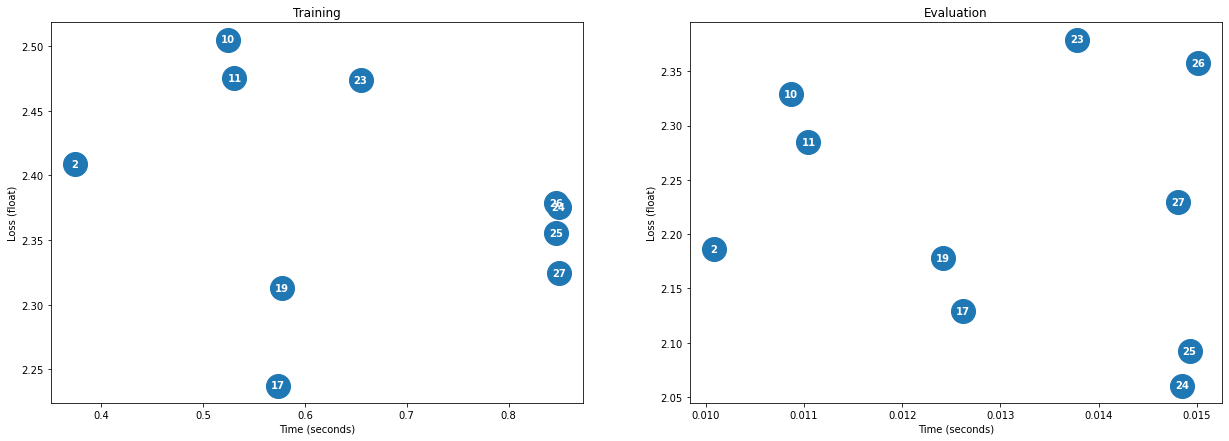

In [13]:
# Plot execution times vs loss

# Initialize plot
fig, axs = plt.subplots(1, 2, figsize=(21, 7))

# Retrieve x and y for training
x_train = _results.train_time.tolist()
y_train = _results.train_loss.tolist()
# Retrieve x and y for evaluation
x_eval = _results.test_time.tolist()
y_eval = _results.test_loss.tolist()
# Retrieve indices
indices = _results.index.tolist()

# Make plot
axs[0].plot(x_train, y_train, 'o', markersize=24)
# Loop through every marker in plot
for j, index in enumerate(indices):
    # Add marker index on point
    axs[0].annotate(xy=(x_train[j], y_train[j]), s='%d' % index,
                    color='white', weight='bold', 
                    horizontalalignment='center',
                    verticalalignment='center')
# Set title and labels
axs[0].set_title('Training')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Loss (float)')

# Make plot
axs[1].plot(x_eval, y_eval, 'o', markersize=24)
# Loop through every marker in plot
for j, index in enumerate(indices):
    # Add marker index on point
    axs[1].annotate(xy=(x_eval[j], y_eval[j]), s='%d' % index,
                    color='white', weight='bold', 
                    horizontalalignment='center',
                    verticalalignment='center')
# Set title and labels
axs[1].set_title('Evaluation')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Loss (float)')

# Save plot
plt.savefig('images/charlie/hyper.png')
# Show plot
plt.show()

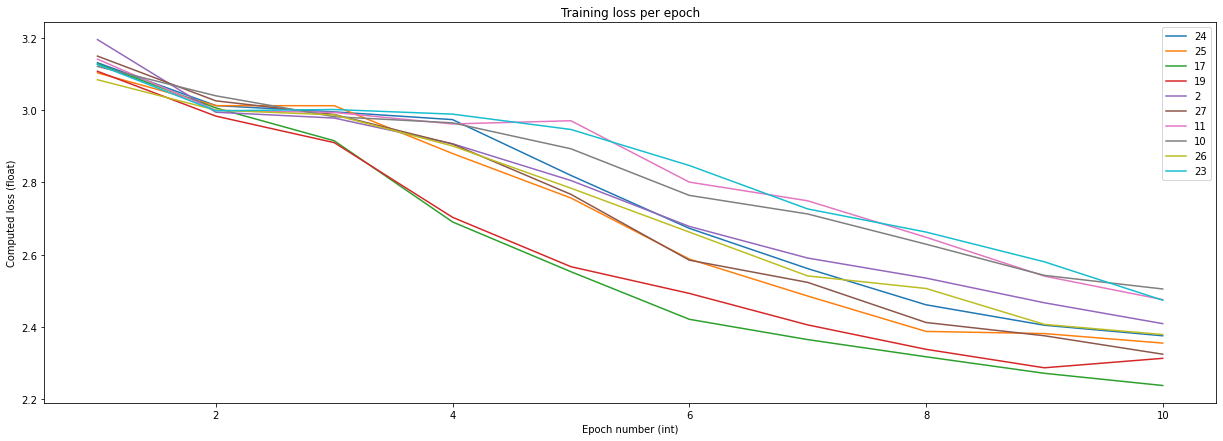

In [14]:
# Plot training loss vs time

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(21, 7))
# Retrieve indices
indices = _results.index.tolist()
# Loop through each train loss in grid search
for i, row in _results.iterrows():
    # Define x (epoch number) and y (loss)
    x = range(1, len(train_losses[i]) + 1)
    y = train_losses[i]
    # Make training scatter
    ax.plot(x, y, '-')
# Set title and labels
ax.set_title('Training loss per epoch')
ax.set_xlabel('Epoch number (int)')
ax.set_ylabel('Computed loss (float)')
# Add legend
ax.legend(['%d' % i for i in indices])
# Show plot
plt.show()

### Model training

Best model has following parameters:
* Number of hidden units: 256
* Number of layers: 3
* Dropout probability: 0.3
* Recurrent layer type: GRU
* Adam optimizer
    * Linear rate: 1e-3
    * Weight decay: 1e-4

In [15]:
# Instantiate new network
net = Charlie(input_size=len(alphabet), hidden_units=256, layers_num=3, hidden_type='GRU', dropout_prob=0.3)
# Move network to device
net.to(device)
# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
# Define loss function
loss_fn = nn.CrossEntropyLoss()
# Show network
net

Charlie(
  (rnn): GRU(34, 256, num_layers=3, batch_first=True, dropout=0.3)
  (out): Linear(in_features=256, out_features=34, bias=True)
)

In [16]:
# Define encode function
def encode_fn(string):
    # Clean input text
    string = dataset.clean_text(string)
    # Split input string in characters
    chars = dataset.split_chars(string)
    # One hot encode characters
    encoded = one_hot_encode(chars)
    # Cast encoded sentence to tensor
    return to_tensor(encoded).unsqueeze(0)
    

# Define decode function
def decode_fn(index):
    return one_hot_encode.decoder.get(index)

In [17]:
# Define number of epochs
num_epochs = NUM_EPOCHS
# Define number of epochs per checkpoint
save_after = SAVE_AFTER

# Do only if model training is enabled
if MODEL_TRAIN:
    # Define actual datetime
    now = datetime.datetime.now()
    # Define training path
    train_path = 'data/charlie/%s' % now.strftime('%Y_%m_%d_%H_%M_%S')
    # Define network path
    net_path = train_path + '/net.pth'
    # Define epochs path
    epochs_path = train_path + '/epochs.json'
    
    # Make directory
    os.makedirs(train_path, exist_ok=True)
    
    # Define verbose seed
    seed = 'Once upon a time there was an happy man'
    # Make train and test
    train_test_epochs(
        net=net, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs,
        train_dl=train_dataloader, test_dl=test_dataloader, 
        seed=seed, crop_len=CROP_LEN, encode_fn=encode_fn, decode_fn=decode_fn,
        save_after=SAVE_AFTER, net_path=net_path, epochs_path=epochs_path,
        verbose=True, device=device
    )

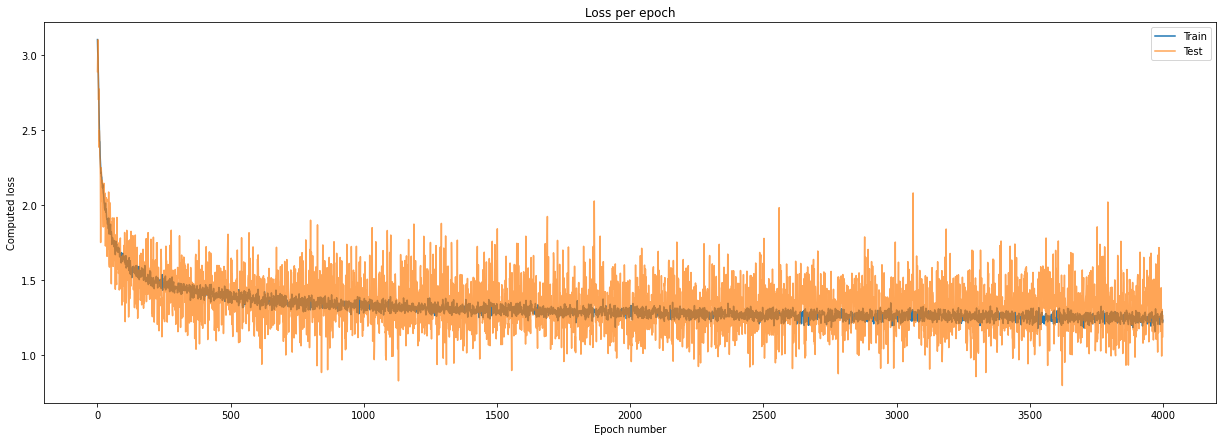

In [18]:
# Show epochs loss

# Load epochs
train_losses, train_times, test_losses, test_times, _ = load_epochs(path=MODEL_PATH + '/epochs.json')
# Define number of epochs
num_epochs = len(train_losses) 

# Initialize plot
fig, ax = plt.subplots(figsize=(21, 7))
# Set title and labels
ax.set_title('Loss per epoch')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Computed loss')
# Plot scatter
ax.plot(range(num_epochs), train_losses, '-')
ax.plot(range(num_epochs), test_losses, '-', alpha=.7)
# Add legend
ax.legend(['Train', 'Test'])
# Save plot
plt.savefig('images/charlie/epochs.png')
# Show plot
plt.show()

In [19]:
# Load network from file
net, _ = Charlie.from_file(path=MODEL_PATH + '/net.pth')
# Set network in evaluation mode
net.eval()

Charlie(
  (rnn): GRU(34, 256, num_layers=3, batch_first=True, dropout=0.3)
  (out): Linear(in_features=256, out_features=34, bias=True)
)

In [20]:
# Define input seed sentence
seed = 'Once upon a time there was a young man'
# Generate text using trained network
generated = net.generate_text(
    # Set seed sentence
    seed=seed,
    # Set encoding function
    encode_fn=encode_fn,
    # Set decoding function
    decode_fn=decode_fn,
    # Number of characters to predict
    num_chars=1000,
    # Decision function
    decision_how='softmax'
)

# Print seed sentence
print('Generated text (seed: "%s")' % seed)
# Print generated text
print(generated)

Generated text (seed: "Once upon a time there was a young man")
Once upon a time there was a young man lite dittick."
returned the sergeant "
i daid you, i said " howare do nothing offoed the deml."
wemmick a feel in the name, when as to me joe acadted him of mine,"
said he. "never to him."
said the table, like amaze, dreak, gore back toking my eyes when he say dim found me so?
i eqe and after our fecesmonish, "then he took what day of have shall all vinished dranter all doors of the kitchens parter in it made me, say in the week of scare to me, in a poor offer. "serat, i saw miss havisham had aro look, as i found it was as the cream of the life, good chancely time to last now certainst a hail for some eyes had your deal, but i can esure him far me a pobill that way, and twentyy pounce of the course concesting vising the effect of hair and years.
not smoke his boening name on.
all at me "
was wead of having thavben bredatical ingoctent for me. believe that i was as i could you there, b